In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

In [2]:
demand_df = pd.read_csv(r"C:\Users\ramak\OneDrive\Documents\projects\daily_demand_complete.csv")
demand_df.head()

,Unnamed: 0,order_date,demand
0,0,2016-09-15,1.0
1,1,2016-09-16,0.0
2,2,2016-09-17,0.0
3,3,2016-09-18,0.0
4,4,2016-09-19,0.0


In [3]:
demand_df =  demand_df.iloc[:, 1:]
demand_df = demand_df.set_index('order_date')
demand_df.head()

,demand
order_date,
2016-09-15,1.0
2016-09-16,0.0
2016-09-17,0.0
2016-09-18,0.0
2016-09-19,0.0


In [4]:
demand_df = demand_df['demand']
demand_df.index

Index(['2016-09-15', '2016-09-16', '2016-09-17', '2016-09-18', '2016-09-19',
       '2016-09-20', '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24',
       ...
       '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23', '2018-08-24',
       '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28', '2018-08-29'],
      dtype='object', name='order_date', length=714)

#### A seasonal ARIMA model was evaluated to capture weekly seasonality; however, it resulted in higher MAE and RMSE compared to the baseline ARIMA model. This indicates potential overfitting due to seasonal differencing. Therefore, the simpler ARIMA(2,1,1) model was selected as the final model based on superior out-of-sample performance.

In [5]:
first_order_difference = demand_df - demand_df.shift(1)
first_order_difference = first_order_difference.dropna()
first_order_difference

order_date
2016-09-16    -1.0
2016-09-17     0.0
2016-09-18     0.0
2016-09-19     0.0
2016-09-20     0.0
              ... 
2018-08-25   -27.0
2018-08-26     4.0
2018-08-27    -7.0
2018-08-28   -27.0
2018-08-29   -28.0
Name: demand, Length: 713, dtype: float64

In [6]:
week_order_difference = first_order_difference - first_order_difference.shift(7)
week_order_difference = week_order_difference.dropna()
week_order_difference

order_date
2016-09-23     1.0
2016-09-24     0.0
2016-09-25     0.0
2016-09-26     0.0
2016-09-27     0.0
              ... 
2018-08-25    29.0
2018-08-26    -7.0
2018-08-27   -54.0
2018-08-28   -14.0
2018-08-29    25.0
Name: demand, Length: 706, dtype: float64

In [7]:
from statsmodels.tsa.stattools import adfuller

def DickeyFullerTest(data):
    ad_result = adfuller(data)
    print("ADF Statistic: ", ad_result[0])
    print("P-Value: ", ad_result[1])
    if ad_result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

In [8]:
DickeyFullerTest(week_order_difference)

ADF Statistic:  -8.604072971676699
P-Value:  6.746279503623277e-14
Data is stationary


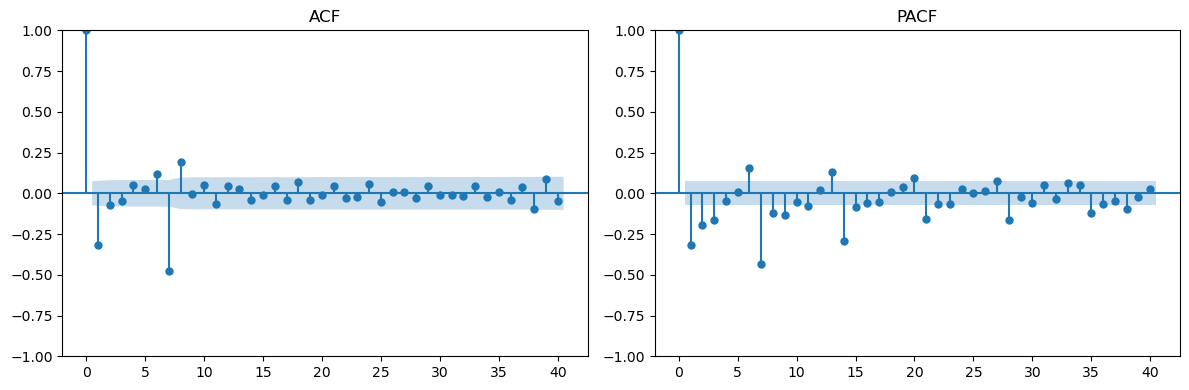

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

plot_acf(week_order_difference, ax = ax[0], lags = 40)
plot_pacf(week_order_difference, ax = ax[1], lags = 40)

ax[0].set_title("ACF")
ax[1].set_title('PACF')

plt.tight_layout()
plt.show()

In [10]:
train = pd.read_csv(r"C:\Users\ramak\OneDrive\Documents\projects\demand_train.csv", parse_dates = ['order_date'])
train = train.set_index('order_date')['0']
train

order_date
2016-09-15      1.0
2016-09-16      0.0
2016-09-17      0.0
2016-09-18      0.0
2016-09-19      0.0
              ...  
2018-04-04    252.0
2018-04-05    261.0
2018-04-06    181.0
2018-04-07    161.0
2018-04-08    183.0
Name: 0, Length: 571, dtype: float64

In [11]:
test = pd.read_csv(r"C:\Users\ramak\OneDrive\Documents\projects\demand.test.csv", parse_dates = ['order_date'])
test = test.set_index('order_date')['demand']
test

order_date
2018-04-09    250.0
2018-04-10    196.0
2018-04-11    262.0
2018-04-12    253.0
2018-04-13    197.0
              ...  
2018-08-25     69.0
2018-08-26     73.0
2018-08-27     66.0
2018-08-28     39.0
2018-08-29     11.0
Name: demand, Length: 143, dtype: float64

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = train.asfreq('D')
model_sarimax = SARIMAX(train, order = (2, 1, 1), seasonal_order = (1, 1, 1, 7))

# 1. Fit the model
model_sarimax_fit = model_sarimax.fit(model = 'powell', maxiter = 200)

# 2. Print the full summary table
print(model_sarimax_fit.summary())

# 3. Specifically check AIC (Lower is generally better)
print(f"AIC: {model_sarimax_fit.aic}")

# 4. Check if the model actually converged (mathematically 'settled')
print(f"Converged: {model_sarimax_fit.mle_retvals['warnflag'] == 0}")

C:\Users\ramak\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: model. After release 0.14, this will raise.
  warnings.warn(


                                     SARIMAX Results                                     
Dep. Variable:                                 0   No. Observations:                  571
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2538.687
Date:                           Sat, 07 Feb 2026   AIC                           5089.373
Time:                                   10:02:02   BIC                           5115.373
Sample:                               09-15-2016   HQIC                          5099.523
                                    - 04-08-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6946      0.025     27.372      0.000       0.645       0.744
ar.L2          0.1110      0.033      3.414

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Forecast the exact length of the test set
test = test.asfreq('D')
forecast_steps = len(test)
forecast_object = model_sarimax_fit.get_forecast(steps=forecast_steps)

# 2. Extract the mean forecast and align the index
# This ensures dates match the test set for plotting and metrics
forecast_values = forecast_object.summary_frame()['mean']
forecast_values.index = test.index 

# Optional: Extract confidence intervals for better visualization
conf_int = forecast_object.summary_frame(alpha=0.05) # 95% confidence

In [14]:
# 3. Evaluate performance
mae = mean_absolute_error(test, forecast_values)
rmse = np.sqrt(mean_squared_error(test, forecast_values))

print(f"--- Evaluation Metrics ---")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

--- Evaluation Metrics ---
MAE:  69.7368
RMSE: 90.8759


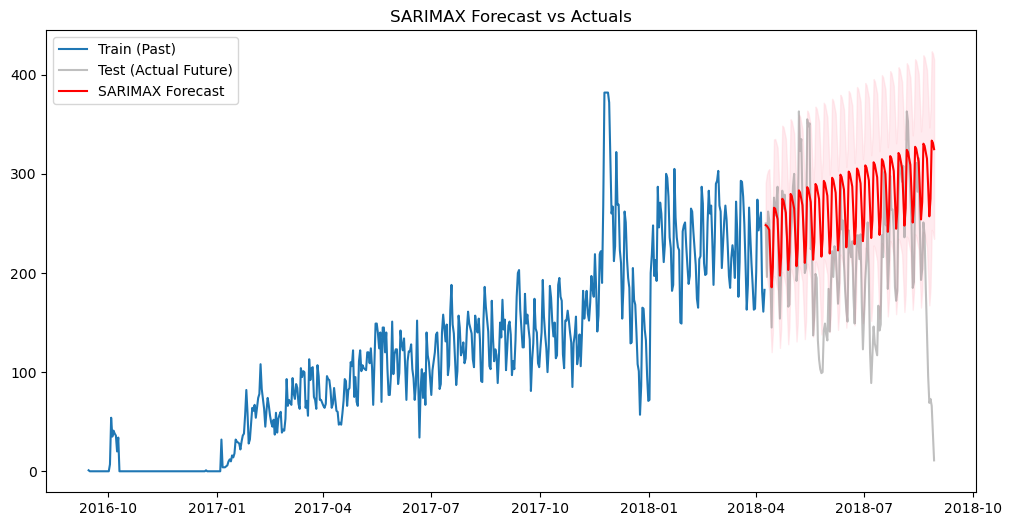

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train (Past)')
plt.plot(test.index, test, label='Test (Actual Future)', color='gray', alpha=0.5)
plt.plot(forecast_values.index, forecast_values, label='SARIMAX Forecast', color='red')

# Shade the confidence interval
plt.fill_between(forecast_values.index, 
                 conf_int['mean_ci_lower'], 
                 conf_int['mean_ci_upper'], 
                 color='pink', alpha=0.3)

plt.title("SARIMAX Forecast vs Actuals")
plt.legend()
plt.show()